In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models, regularizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from tensorflow.keras.models import load_model

2024-12-10 12:58:33.669076: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 12:58:33.855632: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-10 12:58:34.041028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733831914.204248    3270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733831914.250804    3270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 12:58:34.633516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [8]:
train_data_dir= "../data/raw_data/Training"
test_data_dir = "../data/raw_data/Testing"

In [9]:
# Training and validation datasets
X_train = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16  # Batch size
)

X_val = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="validation",  # Specify the subset
    seed=42,  # Ensure reproducibility
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16  # Batch size
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [10]:
# Test dataset
X_test = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=16,  # Batch size
    shuffle=False
)

Found 1311 files belonging to 4 classes.


In [11]:
# Normalize images to [0, 1]
def normalize_0_1(image, label):
    return image / 255.0, label

# Convert labels to one-hot encoding
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=4)  # Convert label to one-hot encoding (4 classes)
    return image, label

In [12]:
# Apply the normalization and one-hot encoding to the datasets
X_train = X_train.map(normalize_0_1).map(one_hot_encode)
X_val = X_val.map(normalize_0_1).map(one_hot_encode)
X_test = X_test.map(normalize_0_1).map(one_hot_encode)

In [ ]:
# ImageDataGenerator with rescaling for preprocessing
#train_data_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)
#test_data_generator = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Training set
#X_train = train_data_generator.flow_from_directory(
#    train_data_dir,
#    target_size=(128, 128),
#    batch_size=16,
#    class_mode="categorical",
#    subset="training"  # Use the training subset
#)

# Validation set
#X_val = train_data_generator.flow_from_directory(
#    train_data_dir,
#    target_size=(128, 128),
#    batch_size=16,
#    class_mode="categorical",
#    subset="validation"  # Use the validation subset
#)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [ ]:
# Create the validation generator
#X_test = test_data_generator.flow_from_directory(
#    test_data_dir,
#    target_size=(128, 128),
#    batch_size=16,
#    class_mode="categorical"
#)

Found 1311 images belonging to 4 classes.


In [ ]:
#batch_images, batch_labels=next(X_train)
#print("Train batch image shape: ", batch_images.shape)
#print("Train batch labels shape: ", batch_labels.shape)

TypeError: '_PrefetchDataset' object is not an iterator

In [7]:
# Function to convert images to grayscale
#def convert_to_grayscale(image, label):
#    grayscale_image = tf.image.rgb_to_grayscale(image)  # Convert to grayscale
#    return grayscale_image, label

In [8]:
# Create the training dataset directly from the generator
#X_train = tf.data.Dataset.from_generator(
#    lambda: iter(X_train),  # Convert flow_from_directory generator to iterator
#    output_signature=(
#        tf.TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32),  # Original shape before conversion
#        tf.TensorSpec(shape=(16, 4), dtype=tf.float32)  # One-hot encoded labels
#    )
#)

# Apply grayscale conversion to the training dataset
#X_train = X_train.map(lambda image, label: convert_to_grayscale(image, label))

In [9]:
# Create the validation dataset directly from the generator
#X_val = tf.data.Dataset.from_generator(
#    lambda: iter(X_val),  # Convert flow_from_directory generator to iterator
#    output_signature=(
#        tf.TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32),  # Original shape before conversion
#        tf.TensorSpec(shape=(16, 4), dtype=tf.float32)  # One-hot encoded labels
#    )
#)

# Apply grayscale conversion to the validation dataset
#X_val = X_val.map(lambda image, label: convert_to_grayscale(image, label))

In [99]:
# Sequential model
model = models.Sequential()

In [ ]:
# Input Layer (128x128x1)
model.add(layers.InputLayer(input_shape=(128, 128, 3)))

# Block 1 (3x3 Conv)
model.add(layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 2 (5x5 Conv)
model.add(layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 3 (3x3 Conv)
model.add(layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 4 (5x5 Conv)
model.add(layers.Conv2D(256, kernel_size=(5, 5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Block 5 (3x3 Conv)
model.add(layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.BatchNormalization())  # Added Batch Normalization

# Global Average Pooling Layer
model.add(layers.GlobalAveragePooling2D())

# Dropout Layer
model.add(layers.Dropout(0.2))

# Dense Layer for Classification (4 classes: Glioma, Meningioma, Pituitary, No Tumor)
model.add(layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Adjusted learning rate
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')])

# Print model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131,524 (8.13 MB)

 Trainable params: 2,129,604 (8.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [101]:
# Set up directories for saving the model and TensorBoard logs
checkpoint_dir = './checkpoints'
tensorboard_log_dir = './logs'

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(tensorboard_log_dir, exist_ok=True)

In [102]:
callbacks = [
    # Save the model with the minimum valdiation loss
    ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
                    monitor='val_loss', mode='min', save_best_only=True, verbose=1),

    # Early stopping to stop training when validation loss stops decreasing
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),

    # Reduce learning rate when the validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1),

    # TensorBoard logging
    TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1, write_images=True)
]

In [103]:
# Training the model with callbacks and storing the training history
history = model.fit(
    X_train,  # Training data generator or dataset
    epochs=100,
    batch_size=16,
    validation_data=X_val,  # Validation data generator or dataset
    callbacks=callbacks
)

Epoch 1/100


2024-12-10 11:38:41.498364: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1,64] vs. [1,16]
	 [[{{function_node __inference_one_step_on_data_397866}}{{node LogicalAnd}}]]
2024-12-10 11:38:41.499267: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at segment_reduction_ops_impl.h:505 : INVALID_ARGUMENT: data.shape = [16] does not start with segment_ids.shape = [64]
2024-12-10 11:38:41.499323: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at segment_reduction_ops_impl.h:505 : INVALID_ARGUMENT: data.shape = [16] does not start with segment_ids.shape = [64]


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "/home/gokhan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/gokhan/.pyenv/versions/3.10.6/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/gokhan/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 600, in run_forever

  File "/home/gokhan/.pyenv/versions/3.10.6/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once

  File "/home/gokhan/.pyenv/versions/3.10.6/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_187711/214766672.py", line 2, in <module>

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 82, in train_step

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 492, in compute_metrics

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 333, in update_state

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 20, in update_state

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/metrics/confusion_metrics.py", line 378, in update_state

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/ops/numpy.py", line 3561, in logical_and

  File "/home/gokhan/.pyenv/versions/3.10.6/envs/brainmap/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 1515, in logical_and

Incompatible shapes: [1,64] vs. [1,16]
	 [[{{node LogicalAnd}}]] [Op:__inference_multi_step_on_iterator_398040]

In [78]:
# Find the index of the best validation accuracy
best_epoch_index = np.argmax(history.history['val_accuracy'])

print(f"Best epoch (index) based on validation accuracy: {best_epoch_index}")

Best epoch (index) based on validation accuracy: 12


In [79]:
# Optionally, print specific metrics like accuracy, loss, and AUC
print("\nSpecific Metrics (Training & Validation):")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch_index]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch_index]}")
print(f"Training Loss: {history.history['loss'][best_epoch_index]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch_index]}")
print(f"Training Precision: {history.history['precision'][best_epoch_index]}")
print(f"Validation Precision: {history.history['val_precision'][best_epoch_index]}")
print(f"Training Recall: {history.history['recall'][best_epoch_index]}")
print(f"Validation Recall: {history.history['val_recall'][best_epoch_index]}")
print(f"Training AUC: {history.history['auc'][best_epoch_index]}")
print(f"Validation AUC: {history.history['val_auc'][best_epoch_index]}")


Specific Metrics (Training & Validation):
Training Accuracy: 0.9921242594718933
Validation Accuracy: 0.8746713399887085
Training Loss: 0.3559764325618744
Validation Loss: 0.7504166960716248
Training Precision: 0.9923396706581116
Validation Precision: 0.8767605423927307
Training Recall: 0.9919055104255676
Validation Recall: 0.8729184865951538
Training AUC: 0.9998927116394043
Validation AUC: 0.9713491797447205


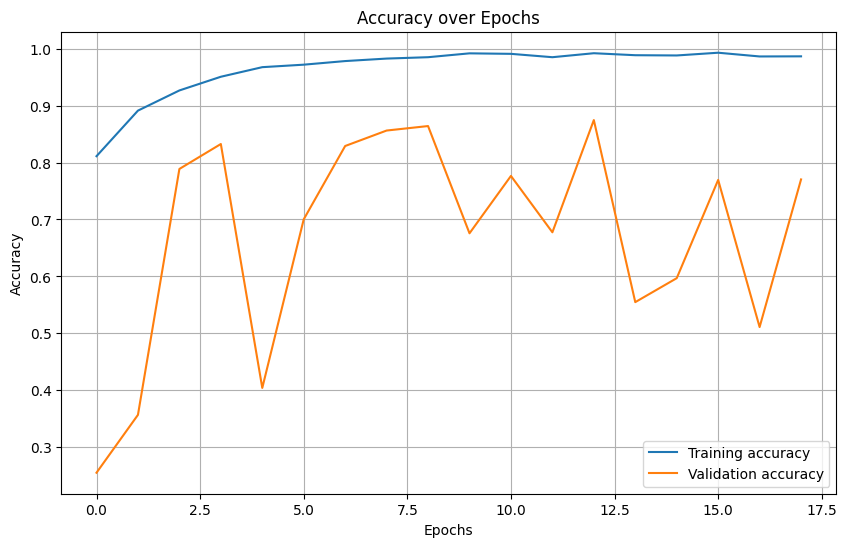

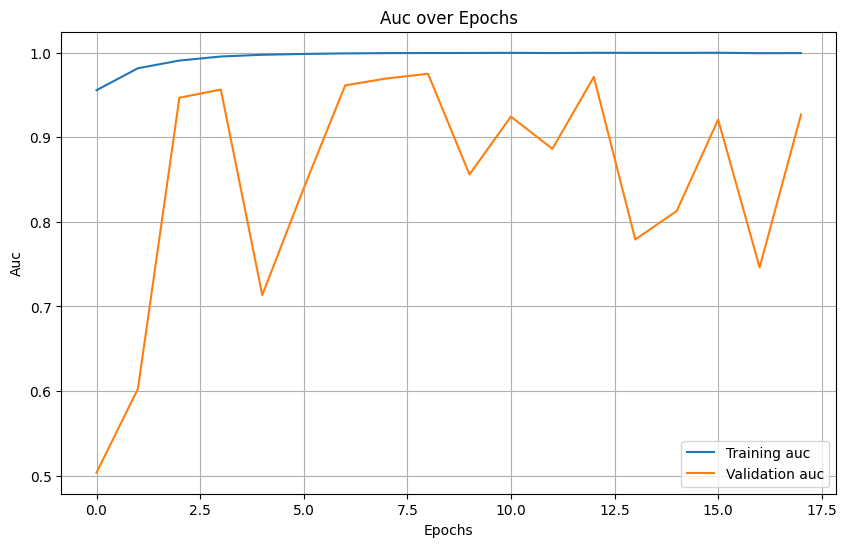

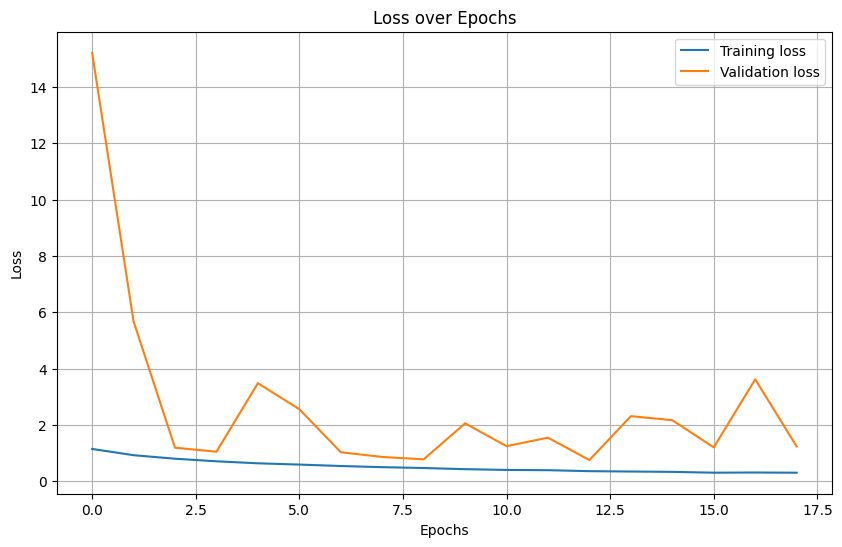

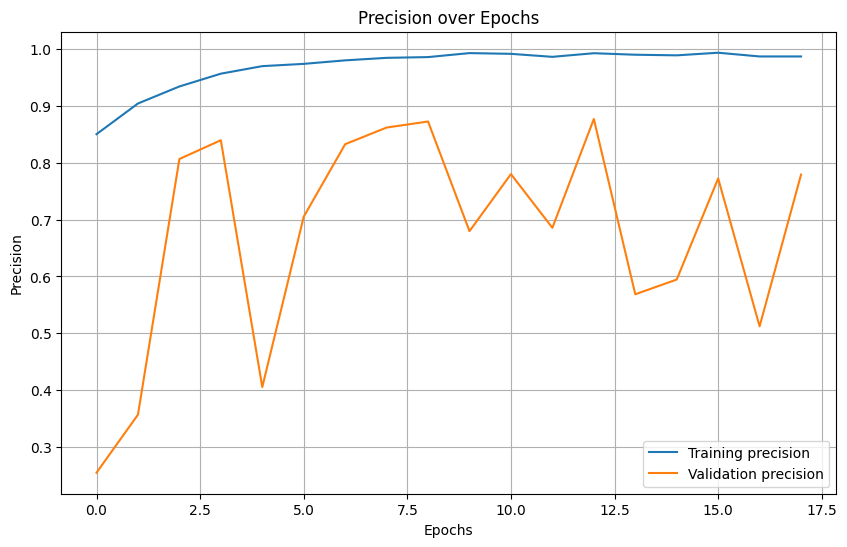

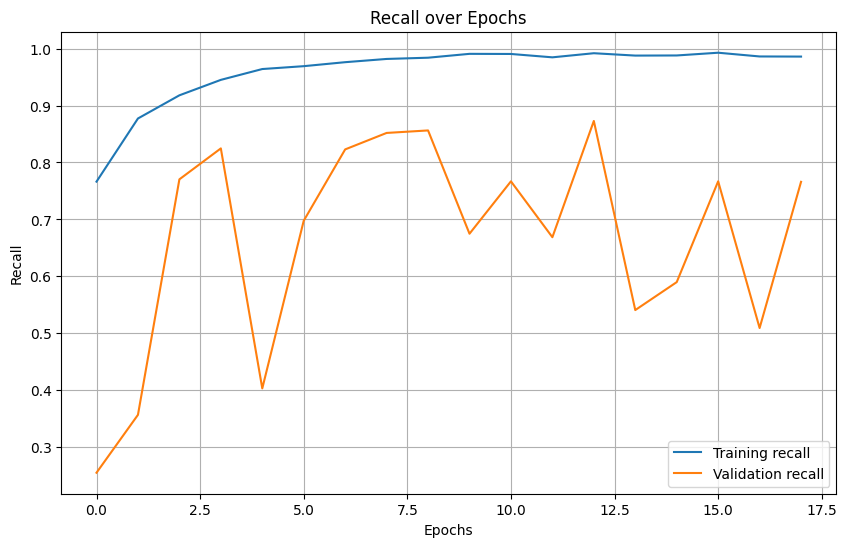

In [24]:
# Define the metrics to plot
metrics = ['accuracy', 'auc', 'loss', 'precision', 'recall']

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# Load the best model
best_model_path = os.path.join(checkpoint_dir, 'partial_checkpoint.keras')
best_model = load_model(best_model_path)

# Evaluate on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9089 - auc: 0.9819 - loss: 0.5298 - precision: 0.9124 - recall: 0.9033
Test Accuracy: 0.9092


In [49]:
from visualkeras import layered_view
from collections import defaultdict

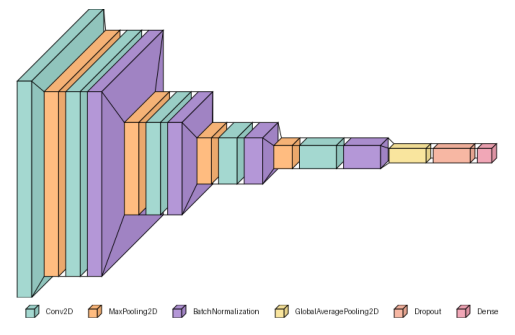

In [ ]:
# Customize the color map for different layers
color_map = defaultdict(dict)
# Custom pastel colors
color_map[layers.Conv2D]['fill'] = "#A4D8D0"  # Light Teal (soft and calming)
color_map[layers.BatchNormalization]['fill'] = "#B497D7"  # Soft Lavender (smooth transition)
color_map[layers.MaxPooling2D]['fill'] = "#FFBC80"  # Light Orange (bright accent)
color_map[layers.GlobalAveragePooling2D]['fill'] = "#F9E59E"  # Soft Yellow (light and airy)
color_map[layers.Dropout]['fill'] = "#F7B7A3"  # Soft Peach (warm, welcoming)
color_map[layers.Dense]['fill'] = "#F1A7B7"  # Muted Coral (vibrant yet soft)

# Visualize the model architecture with the custom color map
img = layered_view(best_model, legend=True, max_xy=300, color_map=color_map)

# Display the image
plt.imshow(img)
plt.axis('off')  # Remove axis for cleaner display
plt.show()

In [25]:
# Get the true labels (y_test) from the test generator
y_test = X_test.labels

82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step


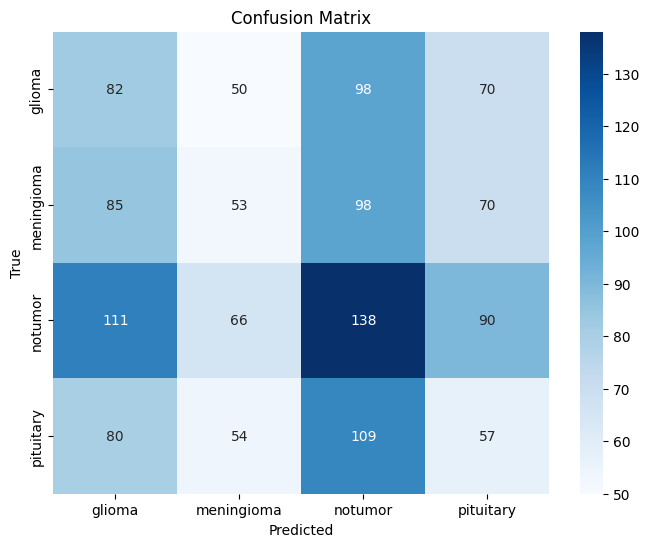

In [60]:
# Get the predicted probabilities for the test set
y_pred_proba = best_model.predict(X_test, verbose=1)

# Convert predicted probabilities to predicted class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# Proceed to calculate metrics like the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=X_test.class_indices.keys(), yticklabels=X_test.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


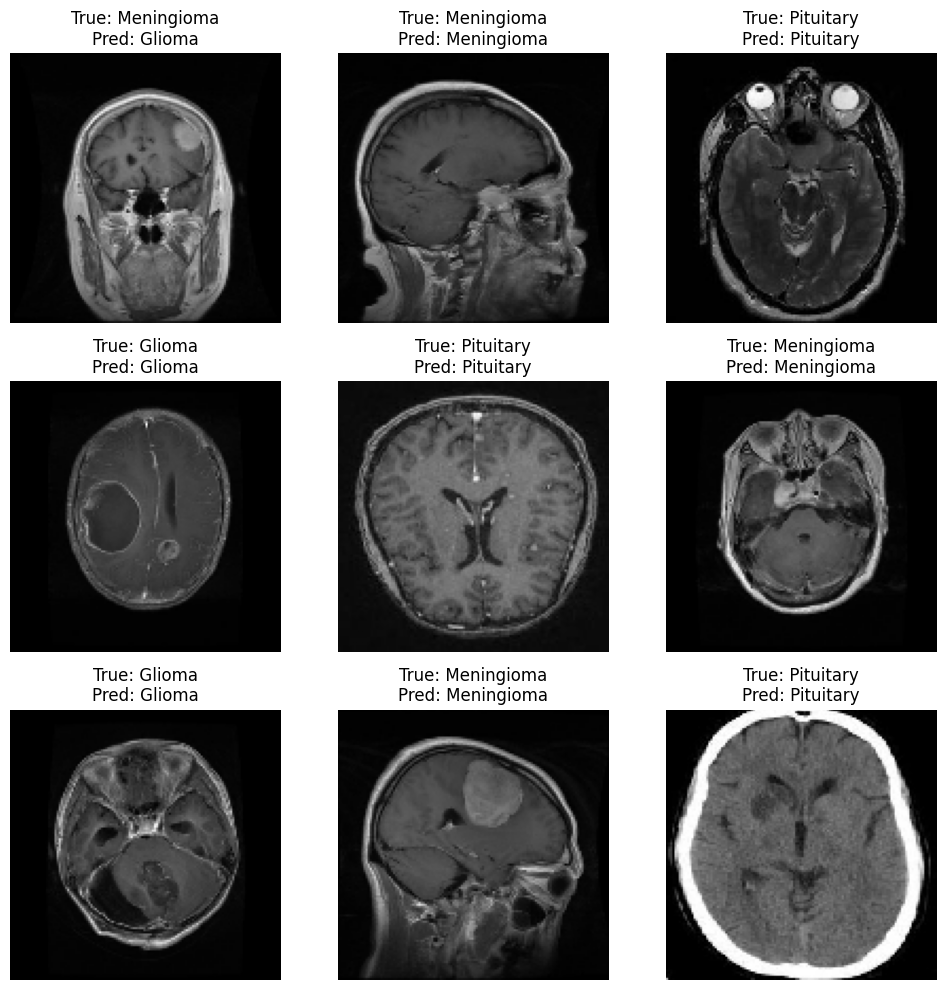

In [69]:
# Fetch a batch of images and labels for visualization
test_images, test_labels = next(X_test)

# Predict on the batch
batch_predictions = best_model.predict(test_images)
batch_predicted_classes = np.argmax(batch_predictions, axis=1)

# Visualize
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[i], cmap='gray')
    true_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[batch_predicted_classes[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#tensorboard --logdir=./logs

In [ ]:
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
X_train, X_valid = train_test_split(train_df,  train_size=0.8 , shuffle= True, random_state= 123)

In [ ]:
X_train.head()

,filepaths,labels
2730,../data/raw_data/Training/pituitary/Tr-pi_0161...,pituitary
4748,../data/raw_data/Training/notumor/Tr-no_1183.jpg,notumor
4811,../data/raw_data/Training/notumor/Tr-no_0256.jpg,notumor
3789,../data/raw_data/Training/pituitary/Tr-pi_0215...,pituitary
1672,../data/raw_data/Training/meningioma/Tr-me_118...,meningioma


In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( X_train, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


val_gen = val_gen.flow_from_dataframe( X_valid, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


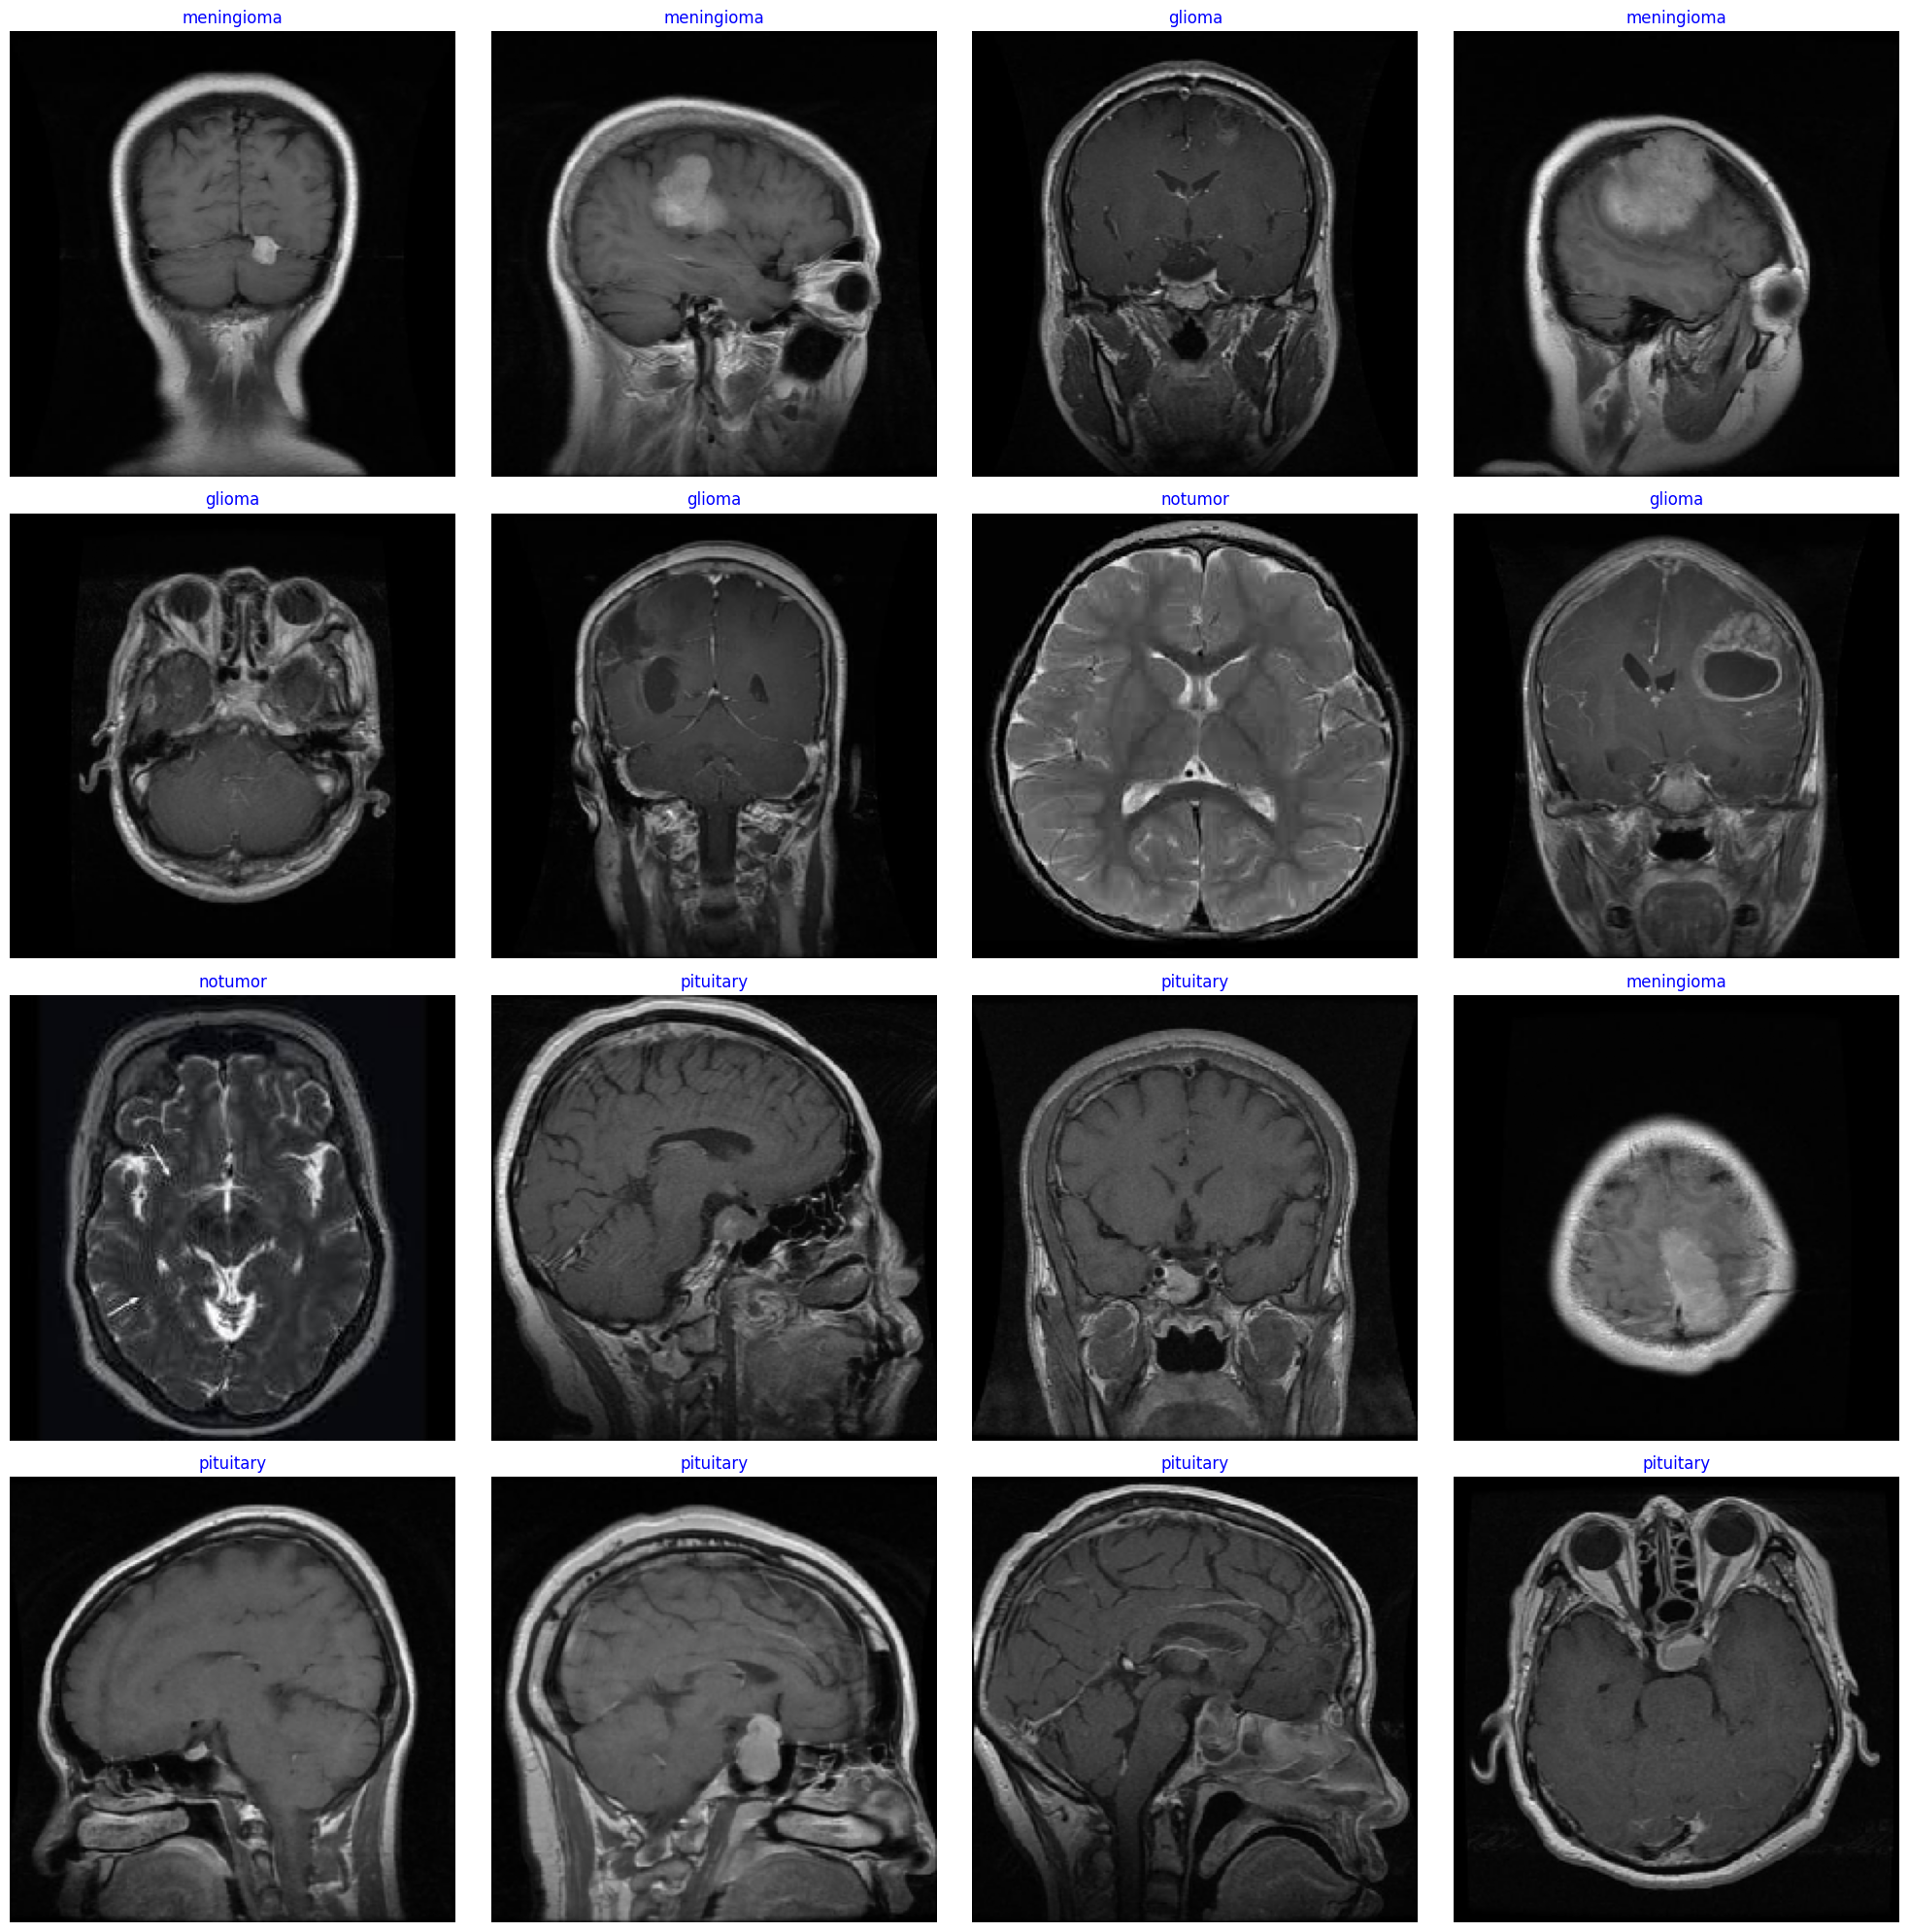

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's keys (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator
# # difference between next iterator and for iterator


plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
X_train["labels"].value_counts(normalize=True)

labels
notumor       0.279054
pituitary     0.252134
meningioma    0.237689
glioma        0.231123
Name: proportion, dtype: float64

In [ ]:
X_valid["labels"].value_counts(normalize=True)

labels
notumor       0.279965
pituitary     0.266842
glioma        0.231846
meningioma    0.221347
Name: proportion, dtype: float64